In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("LCData.csv")
df = df.drop(columns=df.columns[0])

# Home ownership mapping process simplified using get_dummies
df = pd.get_dummies(df, columns=['home_ownership'], drop_first=True)

# Purpose mapping simplified using get_dummies
df = pd.get_dummies(df, columns=['purpose_p'], drop_first=True)

# Use get_dummies for verification_status as well
df = pd.get_dummies(df, columns=['verification_status'], drop_first=True)
df = pd.get_dummies(df, columns=['grade'], drop_first=True)
df = pd.get_dummies(df, columns=['term'], drop_first=True)
df = pd.get_dummies(df, columns=['initial_list_status'], drop_first=True)

# Employment Length changed to Employed as Francesco did
df['employed'] = df['emp_length_p'].map({np.nan: 0, 0.0: 1, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1, 5.0: 1, 6.0: 1, 7.0: 1, 8.0: 1, 9.0: 1, 10.0: 1})
df = df.drop('emp_length_p', axis=1)

# Drop addr_state
df = df.drop('addr_state', axis=1)

# Drop issue_d
df = df.drop('issue_d', axis=1)

# Map def_flag to 0 and 1
df['def_flag'] = df['def_flag'].astype(int)

# Map boolean columns automatically
for column in df.columns:
    if df[column].dtype == bool:
        df[column] = df[column].astype(int)

# Implement np.log on loan_amnt, avg_cur_bal, annual_inc, int_rate
df['log_loan_amnt'] = np.log(df['loan_amnt'])
df = df.drop('loan_amnt', axis=1)
df['log_avg_cur_bal'] = np.log(df['avg_cur_bal'], out=np.zeros_like(df['avg_cur_bal']), where=(df['avg_cur_bal']!=0))
df = df.drop('avg_cur_bal', axis=1)
df['log_annual_inc'] = np.log(df['annual_inc'], out=np.zeros_like(df['annual_inc']), where=(df['annual_inc']!=0))
df = df.drop('annual_inc', axis=1)
df['log_int_rate'] = np.log(df['int_rate'])
df = df.drop('int_rate', axis=1)
df['log_revol_bal'] = np.log(df['revol_bal'], out=np.zeros_like(df['revol_bal']), where=(df['revol_bal']!=0))
df = df.drop('revol_bal', axis=1)

# Drop rows with NaN values
df = df.dropna()

df


c:\Users\shinw\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\shinw\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\shinw\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,def_flag,delinq_2yrs,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,dti,inq_last_6mths,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,...,grade_6,grade_7,term_60,initial_list_status_w,employed,log_loan_amnt,log_avg_cur_bal,log_annual_inc,log_int_rate,log_revol_bal
0,0,0,0,0,0,14.69,0,180,6,5,...,0,0,0,0,1,9.852194,9.271153,11.407565,2.317474,10
1,0,1,0,0,0,6.47,0,161,1,1,...,0,0,1,1,1,10.357743,10.479061,11.884489,2.866193,10
2,0,0,0,0,0,15.55,0,107,6,6,...,0,0,0,0,1,9.390576,10.197201,10.714418,2.683758,8
3,0,6,0,0,0,27.31,2,187,28,10,...,0,0,0,1,1,9.104980,8.069968,10.778956,2.650421,8
4,0,0,0,0,0,21.61,0,211,9,9,...,0,0,0,1,1,8.794825,9.486683,10.968198,1.796747,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157080,0,0,0,0,0,13.88,0,244,7,7,...,0,0,0,1,1,8.779557,9.311000,10.308953,2.457021,8
157081,0,0,0,0,0,14.70,1,333,2,2,...,0,0,1,1,1,9.862666,10.602319,12.432012,2.832625,12
157082,0,0,0,0,0,27.55,0,352,1,1,...,0,0,0,1,1,8.779557,10.220959,10.736397,2.457021,9
157083,0,0,0,0,0,23.16,2,119,5,5,...,0,0,1,0,1,9.210340,8.896999,10.596635,2.564180,9


In [19]:
# Exclude 'def_flag' column for StandardScaler
columns_to_scale = df.columns.drop('def_flag')
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the final preprocessed dataframe
df

,def_flag,delinq_2yrs,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,dti,inq_last_6mths,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,...,grade_6,grade_7,term_60,initial_list_status_w,employed,log_loan_amnt,log_avg_cur_bal,log_annual_inc,log_int_rate,log_revol_bal
0,0,-0.383092,-0.071628,-0.091848,-0.017335,-0.418667,-0.729941,-0.062396,-0.438034,-0.343186,...,-0.165443,-0.083977,-0.670798,-1.050584,0.232382,0.659167,0.314971,0.635147,-0.762582,1.127111
1,0,0.724253,-0.071628,-0.091848,-0.017335,-1.444866,-0.729941,-0.266262,-0.747297,-0.798000,...,-0.165443,-0.083977,1.490762,0.951852,0.232382,1.434256,1.347267,1.550128,0.896657,1.127111
2,0,-0.383092,-0.071628,-0.091848,-0.017335,-0.311303,-0.729941,-0.845670,-0.438034,-0.229483,...,-0.165443,-0.083977,-0.670798,-1.050584,0.232382,-0.048568,1.106385,-0.694659,0.345001,-0.730965
3,0,6.260973,-0.071628,-0.091848,-0.017335,1.156837,1.204006,0.012713,0.922722,0.225331,...,-0.165443,-0.083977,-0.670798,0.951852,0.232382,-0.486434,-0.711578,-0.570841,0.244197,-0.730965
4,0,-0.383092,-0.071628,-0.091848,-0.017335,0.445239,-0.729941,0.270228,-0.252477,0.111627,...,-0.165443,-0.083977,-0.670798,0.951852,0.232382,-0.961952,0.499167,-0.207779,-2.337177,0.198073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157080,0,-0.383092,-0.071628,-0.091848,-0.017335,-0.519789,-0.729941,0.624311,-0.376182,-0.115779,...,-0.165443,-0.083977,-0.670798,0.951852,0.232382,-0.985360,0.349025,-1.472545,-0.340612,-0.730965
157081,0,-0.383092,-0.071628,-0.091848,-0.017335,-0.417418,0.237033,1.579262,-0.685445,-0.684296,...,-0.165443,-0.083977,1.490762,0.951852,0.232382,0.675222,1.452604,2.600554,0.795153,2.985187
157082,0,-0.383092,-0.071628,-0.091848,-0.017335,1.186799,-0.729941,1.783128,-0.747297,-0.798000,...,-0.165443,-0.083977,-0.670798,0.951852,0.232382,-0.985360,1.126689,-0.652492,-0.340612,0.198073
157083,0,-0.383092,-0.071628,-0.091848,-0.017335,0.638743,1.204006,-0.716913,-0.499887,-0.343186,...,-0.165443,-0.083977,1.490762,-1.050584,0.232382,-0.324899,-0.004786,-0.920626,-0.016582,0.198073


Alpha: 0.001
Selected Feature Variables:
Index(['log_int_rate', 'log_loan_amnt', 'grade_5', 'dti', 'grade_6',
       'log_annual_inc'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.346593
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               def_flag   No. Observations:               125664
Model:                          Logit   Df Residuals:                   125657
Method:                           MLE   Df Model:                            6
Date:                Fri, 16 Jun 2023   Pseudo R-squ.:                 0.05612
Time:                        14:58:20   Log-Likelihood:                -43554.
converged:                       True   LL-Null:                       -46144.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------

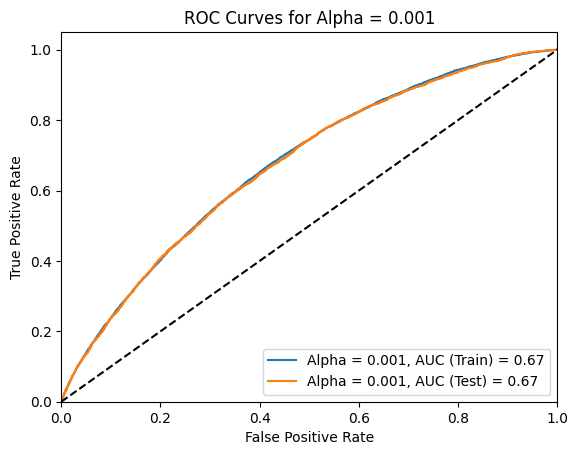

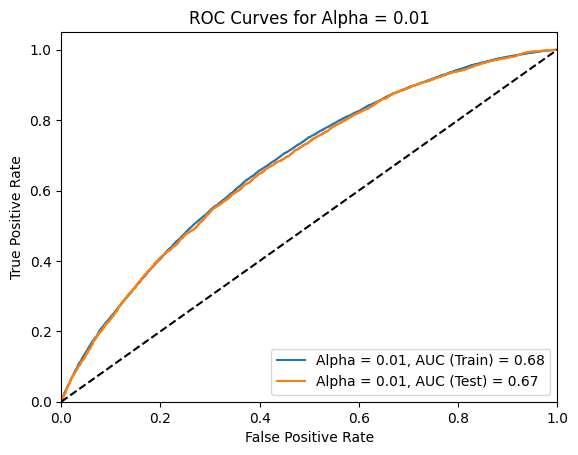

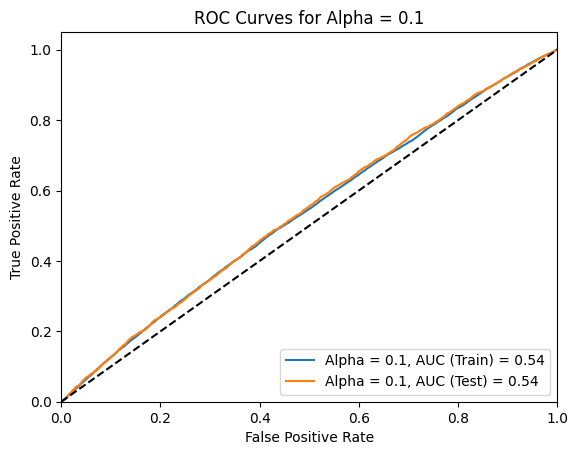

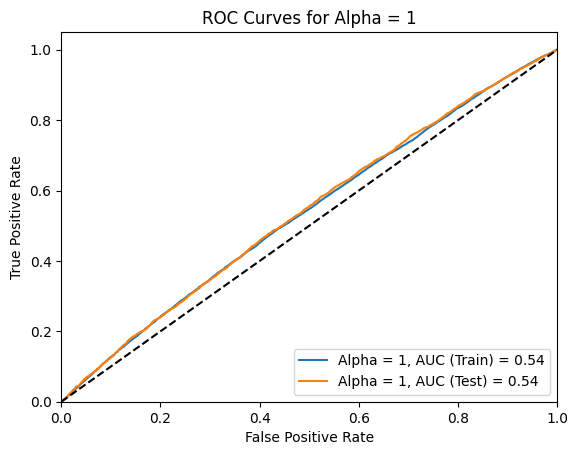

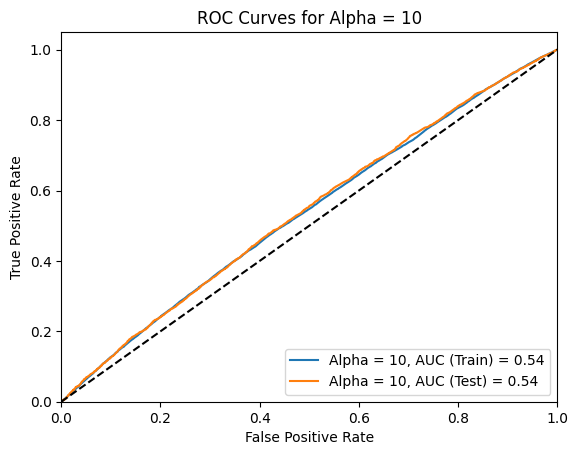

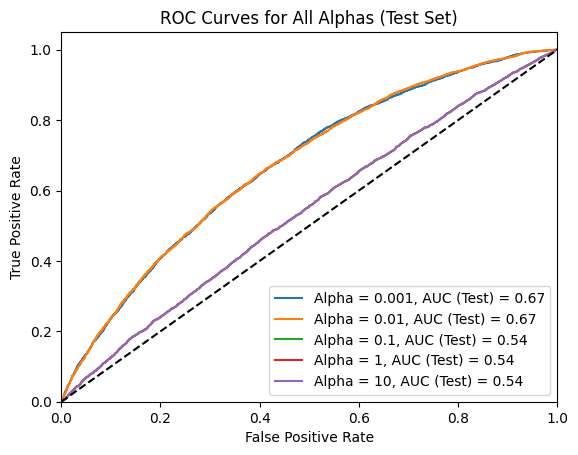

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('def_flag', axis=1), df['def_flag'], test_size=0.2, random_state=42)

# Define a list of alpha values to test
alpha_values = [0.001, 0.01, 0.1, 1, 10]

# Initialize lists to store fpr, tpr, and roc_auc for each alpha value
all_fpr_train = []
all_tpr_train = []
all_roc_auc_train = []
all_fpr_test = []
all_tpr_test = []
all_roc_auc_test = []

# Iterate over alpha values and evaluate the Lasso model
for alpha in alpha_values:
    # Fit Lasso model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    # Get the coefficients (importance) of each variable
    coef = lasso.coef_

    # Get the absolute values of coefficients for feature importance
    importance = np.abs(coef)

    # Sort feature importance in descending order
    sorted_indices = np.argsort(importance)[::-1]

    # Select the top 6 important feature variables
    selected_features = df.drop('def_flag', axis=1).columns[sorted_indices[:6]]

    # Print the chosen feature variables
    print("Alpha:", alpha)
    print("Selected Feature Variables:")
    print(selected_features)
    print()

    # Add constant to X_train for logistic regression
    X_train_const = sm.add_constant(X_train[selected_features])

    # Fit logistic regression model
    logreg = sm.Logit(y_train, X_train_const)
    results_log = logreg.fit()

    # Generate predictions on train set
    y_pred_train = results_log.predict(X_train_const)

    # Calculate fpr, tpr, and roc_auc for train set
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Store fpr, tpr, and roc_auc for train set
    all_fpr_train.append(fpr_train)
    all_tpr_train.append(tpr_train)
    all_roc_auc_train.append(roc_auc_train)

    # Generate predictions on test set
    X_test_const = sm.add_constant(X_test[selected_features])
    y_pred_test = results_log.predict(X_test_const)

    # Calculate fpr, tpr, and roc_auc for test set
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Store fpr, tpr, and roc_auc for test set
    all_fpr_test.append(fpr_test)
    all_tpr_test.append(tpr_test)
    all_roc_auc_test.append(roc_auc_test)

    # Print logistic regression results summary
    print(results_log.summary())
    print()

    # Print AUC and AIC
    print("AUC (Train):", roc_auc_train)
    print("AUC (Test):", roc_auc_test)
    print("AIC:", results_log.aic)
    print()

# Plot ROC curves for each alpha value
for i, alpha in enumerate(alpha_values):
    plt.plot(all_fpr_train[i], all_tpr_train[i], label='Alpha = {}, AUC (Train) = {:.2f}'.format(alpha, all_roc_auc_train[i]))
    plt.plot(all_fpr_test[i], all_tpr_test[i], label='Alpha = {}, AUC (Test) = {:.2f}'.format(alpha, all_roc_auc_test[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Alpha = {}'.format(alpha))
    plt.legend(loc="lower right")
    plt.show()

# Plot all ROC curves in one plot
plt.figure()
for i, alpha in enumerate(alpha_values):
    plt.plot(all_fpr_test[i], all_tpr_test[i], label='Alpha = {}, AUC (Test) = {:.2f}'.format(alpha, all_roc_auc_test[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Alphas (Test Set)')
plt.legend(loc="lower right")
plt.show()


Optimization terminated successfully.
         Current function value: 0.348988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343336
         Iterations 7
Alpha: 0.001
Selected Features (Max AUC): Index(['log_int_rate', 'log_loan_amnt', 'grade_5', 'dti', 'grade_6',
       'log_annual_inc', 'grade_7', 'home_ownership_RENT',
       'mo_sin

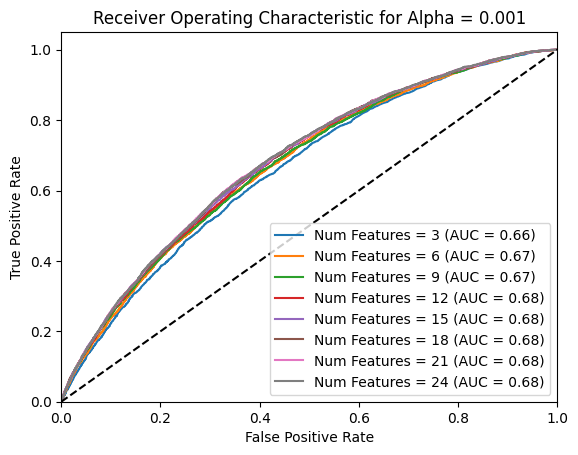

Optimization terminated successfully.
         Current function value: 0.346402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344708
         Iterations 7
Alpha: 0.01
Selected Features (Max AUC): Index(['log_int_rate', 'dti', 'log_avg_cur_bal', 'home_ownership_RENT',
       'log_annual_inc', 'grade_5', 'mo_sin_old_rev_tl_op', 'grade_2',


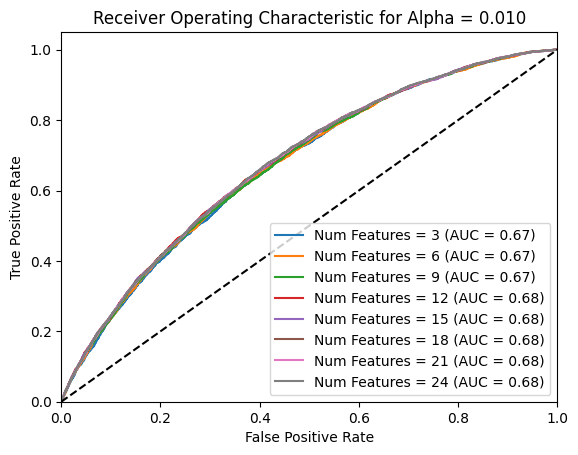

Optimization terminated successfully.
         Current function value: 0.366469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356589
         Iterations 7
Alpha: 0.1
Selected Features (Max AUC): Index(['log_revol_bal', 'num_actv_bc_tl', 'home_ownership_OWN', 'per_cap',
       'pub_rec_bankruptcies', 'pub_rec', 'total_rev_hi_lim', 'total_

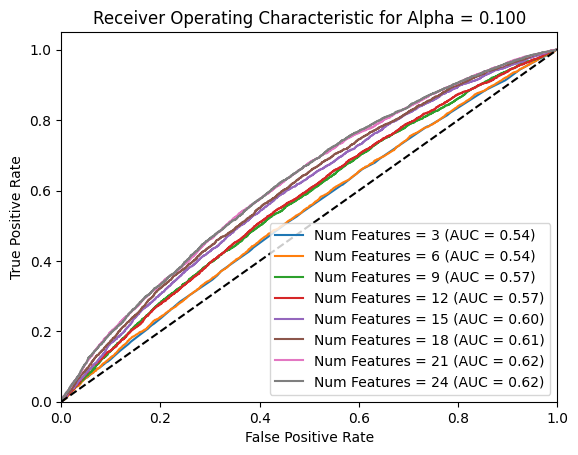

Optimization terminated successfully.
         Current function value: 0.366469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356589
         Iterations 7
Alpha: 1
Selected Features (Max AUC): Index(['log_revol_bal', 'num_actv_bc_tl', 'home_ownership_OWN', 'per_cap',
       'pub_rec_bankruptcies', 'pub_rec', 'total_rev_hi_lim', 'total_ac

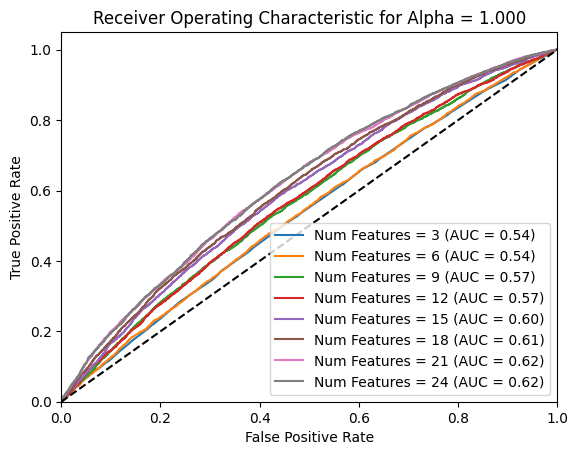

Optimization terminated successfully.
         Current function value: 0.366469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356589
         Iterations 7
Alpha: 10
Selected Features (Max AUC): Index(['log_revol_bal', 'num_actv_bc_tl', 'home_ownership_OWN', 'per_cap',
       'pub_rec_bankruptcies', 'pub_rec', 'total_rev_hi_lim', 'total_a

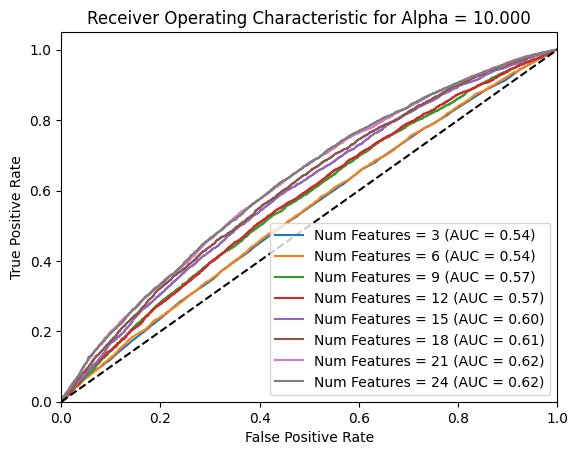

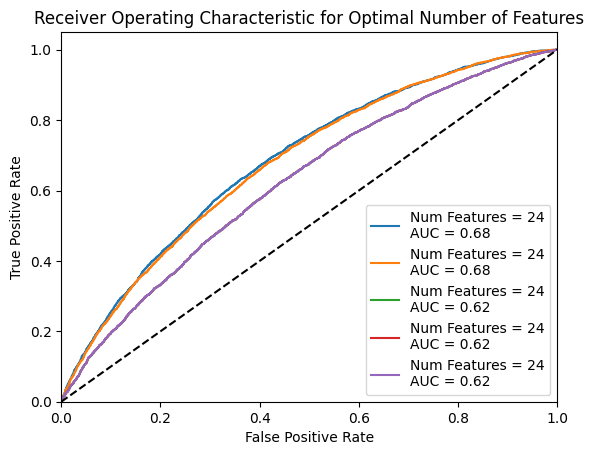

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('def_flag', axis=1), df['def_flag'], test_size=0.2, random_state=42)

# Define a list of alpha values to test
alpha_values = [0.001, 0.01, 0.1, 1, 10]

# Define a list of numbers of selected feature variables to test
num_features_values = [3, 6, 9, 12, 15, 18, 21, 24]

# Initialize lists to store results for each alpha
roc_auc_values = []
selected_features_list = []
aic_values = []
fpr_list = []
tpr_list = []

# Iterate over alpha values
for alpha in alpha_values:
    # Initialize lists to store results for each alpha iteration
    roc_auc_values_alpha = []
    selected_features_list_alpha = []
    aic_values_alpha = []
    fpr_alpha = []
    tpr_alpha = []
    plt.figure()

    # Iterate over numbers of selected feature variables
    for num_features in num_features_values:
        # Fit Lasso model
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)

        # Get the coefficients (importance) of each variable
        coef = lasso.coef_

        # Get the absolute values of coefficients for feature importance
        importance = np.abs(coef)

        # Sort feature importance in descending order
        sorted_indices = np.argsort(importance)[::-1]

        # Select the top feature variables
        selected_features = df.drop('def_flag', axis=1).columns[sorted_indices[:num_features]]
        selected_features_list_alpha.append(selected_features)

        # Add constant to X_train for logistic regression
        X_train_const = sm.add_constant(X_train[selected_features])

        # Fit logistic regression model
        logreg = sm.Logit(y_train, X_train_const)
        results_log = logreg.fit()

        # Generate predictions on test set
        X_test_const = sm.add_constant(X_test[selected_features])
        y_pred = results_log.predict(X_test_const)

        # Calculate AUC for test set
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        roc_auc_values_alpha.append(roc_auc)
        fpr_alpha.append(fpr)
        tpr_alpha.append(tpr)

        # Calculate AIC
        n = len(y_train)
        k = num_features + 1  # +1 for the intercept term
        log_likelihood = -2 * results_log.llf
        aic = 2 * k - 2 * log_likelihood
        aic_values_alpha.append(aic)

        # Plot ROC curve
        plt.plot(fpr, tpr, label='Num Features = %d (AUC = %0.2f)' % (num_features, roc_auc))

    # Find the index of the maximum AUC
    max_auc_index = np.argmax(roc_auc_values_alpha)

    # Store the results for the alpha iteration
    roc_auc_values.append(roc_auc_values_alpha[max_auc_index])
    selected_features_list.append(selected_features_list_alpha[max_auc_index])
    aic_values.append(aic_values_alpha[max_auc_index])
    fpr_list.append(fpr_alpha)
    tpr_list.append(tpr_alpha)

    # Print AUC, AIC, and logistic regression summary for the alpha iteration
    print("Alpha:", alpha)
    print("Selected Features (Max AUC):", selected_features_list_alpha[max_auc_index])
    print("Logistic Regression Summary:")
    print(results_log.summary())
    print("AUC:", roc_auc_values_alpha[max_auc_index])
    print("AIC:", aic_values_alpha[max_auc_index])
    print()
    
    # Plot ROC curves for all numbers of selected feature variables in the alpha iteration
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Alpha = %0.3f' % alpha)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for the selected feature variables with maximum AUC for each alpha
plt.figure()
labels = ['Num Features = %d\nAUC = %0.2f' % (len(selected_features_list[i]), roc_auc_values[i])
          for i in range(len(alpha_values))]
for i in range(len(alpha_values)):
    plt.plot(fpr_list[i][max_auc_index], tpr_list[i][max_auc_index], label=labels[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Optimal Number of Features')
plt.legend(loc="lower right")
plt.show()
